### Part II: Variational AutoEncoder (MNIST data)

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

# We need to install the package 'torchvision' >> pip install torchvision
from torchvision import datasets, transforms

In [2]:
# The code can run on gpu (or) cpu, we can use the gpu if available. 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# To transform images into Tensors
transforms2 = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms2)

test_dataset = datasets.MNIST(
    './data',
    train=False,
    download=True,
    transform=transforms2
)

In [4]:
BATCH_SIZE = 256         # number of data points in each batch
N_EPOCHS = 50           # times to run the model on complete data
INPUT_DIM = 28 * 28     # size of each input
HIDDEN_DIM = 500        # hidden dimension
LATENT_DIM = 2         # latent vector dimension
lr = 1e-2               # learning rate
print(N_EPOCHS)

50


In [5]:
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [6]:
class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, z_dim):
        
        '''
        Args:
            input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
            hidden_dim: A integer indicating the size of hidden dimension.
            z_dim: A integer indicating the latent dimension.
        '''
        
        super().__init__()

        self.linear = nn.Linear(input_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.var = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        
        # x is of shape [batch_size, input_dim]
        hidden = F.relu(self.linear(x))
        
        # hidden is of shape [batch_size, hidden_dim]
        z_mu = self.mu(hidden)
        
        # z_mu is of shape [batch_size, latent_dim]
        z_var = self.var(hidden)
        
        # z_var is of shape [batch_size, latent_dim]
        return z_mu, z_var

    
class Decoder(nn.Module):

    def __init__(self, z_dim, hidden_dim, output_dim):
        
        '''
        Args:
            z_dim: A integer indicating the latent size.
            hidden_dim: A integer indicating the size of hidden dimension.
            output_dim: A integer indicating the output dimension (in case of MNIST it is 28 * 28)
        '''
        
        super().__init__()

        self.linear = nn.Linear(z_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        
        # x is of shape [batch_size, latent_dim]
        hidden = F.relu(self.linear(x))
        
        # hidden is of shape [batch_size, hidden_dim]
        predicted = torch.sigmoid(self.out(hidden))
        
        # predicted is of shape [batch_size, output_dim]
        return predicted

    
class VAE(nn.Module):
    
    def __init__(self, enc, dec):
        
        super().__init__()
        
        self.enc = enc
        self.dec = dec

    def forward(self, x):
        
        # encode
        z_mu, z_var = self.enc(x)

        # sample from the distribution having latent parameters z_mu, z_var
        # reparameterize
        std = torch.sqrt( torch.exp( z_var ) )
        eps = torch.normal(0, 1., z_mu.shape)
        x_sample = z_mu + eps * std

        # decode
        predicted = self.dec(x_sample)
        return predicted, z_mu, z_var

In [7]:
# encoder
encoder = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM)

# decoder
decoder = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM)

# vae
model = VAE(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [8]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(reconstruction_x, x, z_mean, z_var):
    
    # reconstruction loss
    BCE = F.binary_cross_entropy(reconstruction_x, x.view(-1, 784), reduction='sum')
    # kl divergence loss
    KLD = -0.5 * torch.sum(1 + z_var - z_mean.pow(2) - z_var.exp())

    return BCE + KLD


In [9]:
def train():
    # set the train mode
    model.train()
    torch.nn.utils.clip_grad_value_(model.parameters(), 5.)
    # loss of the epoch
    train_loss = 0

    for i, (x, _) in enumerate(train_iterator):
        
        # reshape the data into [batch_size, 784]
        x = x.view(-1, 28 * 28)
        x = x.to(device)

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        x_sample, z_mu, z_var = model(x)

        # total loss
        loss = loss_function( x_sample, x, z_mu, z_var )

        # backward pass
        loss.backward()
        train_loss += loss.item()

        # update the weights
        optimizer.step()

    return train_loss

In [10]:
def test():
    
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for i, (x, _) in enumerate(test_iterator):
            
            # reshape the data
            x = x.view(-1, 28 * 28)
            x = x.to(device)

            # forward pass
            x_sample, z_mu, z_var = model(x)

            # total loss
            loss = loss_function( x_sample, x, z_mu, z_var )
            test_loss += loss.item()

    return test_loss



In [11]:
best_test_loss = float('inf')

trainLoss = []
testLoss = []

for epoch in range(N_EPOCHS):

    train_loss = train()
    test_loss = test()

    loss = []
    
    train_loss /= len(train_dataset)
    test_loss /= len(test_dataset)
    
    if epoch % 5 == 0:
        print('>> epoch ', epoch)
        print('---> Train loss: >> ', train_loss)
        print('-----> Test loss: >> ', test_loss)
        print('')

    trainLoss.append( train_loss )
    testLoss.append( test_loss )
    
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        patience_counter = 1
    else:
        patience_counter += 1

    if patience_counter > 3:
        break
        

>> epoch  0
---> Train loss: >>  183.36983512369792
-----> Test loss: >>  166.76748679199218

>> epoch  5
---> Train loss: >>  156.05779222005208
-----> Test loss: >>  156.77526645507814

>> epoch  10
---> Train loss: >>  152.9878586751302
-----> Test loss: >>  155.4349696777344

>> epoch  15
---> Train loss: >>  151.47394772135416
-----> Test loss: >>  153.93025380859376

>> epoch  20
---> Train loss: >>  150.49920903320313
-----> Test loss: >>  153.0761112060547



In [12]:
print(trainLoss)
print(testLoss)


[183.36983512369792, 164.19824847005208, 160.75430205078126, 158.9898401529948, 157.36066220703125, 156.05779222005208, 155.2438783203125, 154.56341596679687, 154.00074353841146, 153.40057140299479, 152.9878586751302, 152.74965387369792, 152.39922895507812, 152.03949195963543, 151.5647623860677, 151.47394772135416, 151.32601865234375, 151.1571975423177, 150.81848282877604, 150.68074654947915, 150.49920903320313, 150.2085170247396, 150.0712862467448, 149.81265748697916, 149.73904518229168]
[166.76748679199218, 163.02494624023439, 160.18760390625, 158.850590625, 157.70517404785156, 156.77526645507814, 156.1747416015625, 155.7224591064453, 155.3613291748047, 154.21725336914062, 155.4349696777344, 154.8737732421875, 153.86329279785156, 153.9919579345703, 153.30861374511719, 153.93025380859376, 153.06774663085938, 153.39946591796874, 152.89774975585937, 152.56960556640624, 153.0761112060547, 152.4363202636719, 152.47038771972657, 153.2065001464844, 152.7603096923828]


No handles with labels found to put in legend.


Text(0, 0.5, 'Loss')

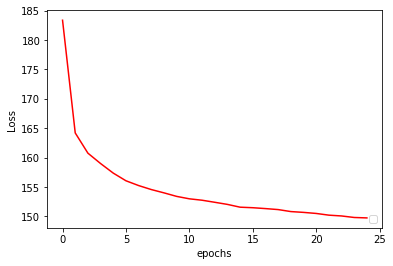

In [13]:
plt.plot(trainLoss[:], 'r')
plt.legend(loc='lower right')
plt.xlabel("epochs")
plt.ylabel("Loss")

No handles with labels found to put in legend.


Text(0, 0.5, 'Loss')

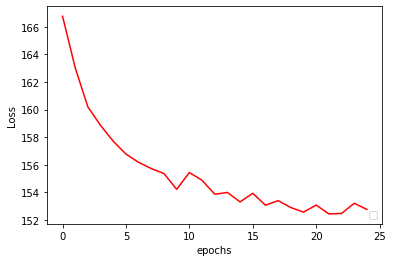

In [14]:
plt.plot(testLoss[:], 'r')
plt.legend(loc='lower right')
plt.xlabel("epochs")
plt.ylabel("Loss")

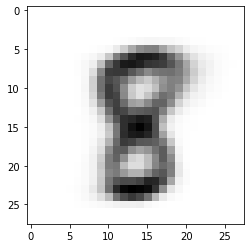

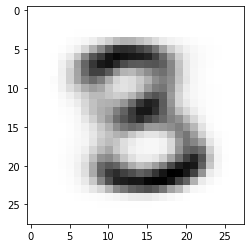

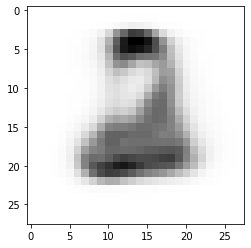

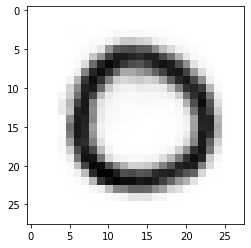

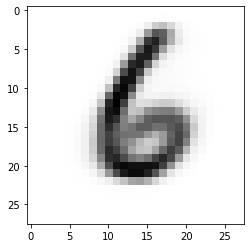

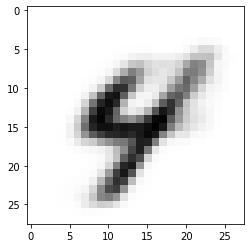

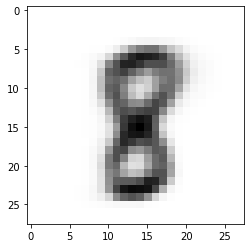

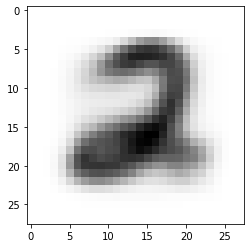

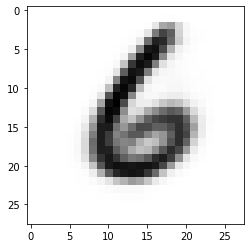

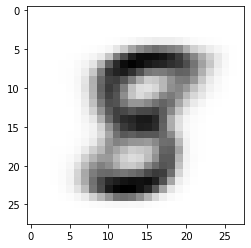

In [15]:
e = torch.normal(0, 1., (HIDDEN_DIM, LATENT_DIM))
images = decoder(e).sigmoid()

for i in range(10):
    picture = images[i].clone().detach().numpy()
    plt.imshow(picture.reshape(28,28), cmap='Greys')
    plt.show()